<a href="https://colab.research.google.com/github/Liamsi4657/Crop_disease_classification/blob/main/Classification_Crop1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm
!pip install torchmetrics
import os, torch, json, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import random
from matplotlib import pyplot as plt
import os
import shutil
from zipfile import ZipFile
import timm
import torchmetrics
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(2024)



def unzip_and_structure_data(source_path, destination_path):
    # Unzip files from source to unzipped
    if not os.path.exists(destination_path):
        with ZipFile(source_path, 'r') as zip_ref:
            zip_ref.extractall(destination_path)
        print("Files unzipped successfully.")
    else:
        print("Unzipped files already exist.")

unzip_and_structure_data('/content/drive/MyDrive/Colab Notebooks/Data.zip','/content/kaggle/input/crop-diseases-classification/')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [11]:
class CustomDataset(Dataset):

    def __init__(self, root, transformations=None):
        self.transformations = transformations
        # Read meta data
        meta_data = pd.read_csv(f"{root}/train.csv")

        # Read json file and get class names dictionary
        with open(f"{root}/label_num_to_disease_map.json") as json_file: data = json.load(json_file)
        self.cls_names = {int(key): value for key, value in data.items() }

        # Get image file names and their corresponding labels
        im_names = list(meta_data["image_id"])
        gt_names = list(meta_data["label"])
        self.meta_data = {}

        self.cls_counts, count, data_count = {}, 0, 0
        for idx, im_path in enumerate(im_names):
            fname = f"{root}/train_images/{im_path}"
            if not os.path.isfile(fname): continue
            else:
                class_name = self.cls_names[int(gt_names[idx])]
                if class_name not in self.cls_counts: self.cls_counts[class_name] = 1; count += 1
                else: self.cls_counts[class_name] += 1
                self.meta_data[fname] = int(gt_names[idx])



        total_samples = sum(self.cls_counts.values())
        self.class_distribution = {cls_name: count / total_samples for cls_name, count in self.cls_counts.items()}

    def get_class_distribution(self):
        return self.class_distribution

    def __len__(self): return len(self.meta_data)

    def __getitem__(self, idx):

        im_path = list(self.meta_data.keys())[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.meta_data[im_path]

        if self.transformations is not None: im = self.transformations(im)


        return im, gt



def get_dls(root, transformations, bs, split = [0.2, 0.05, 0.75], ns = 2):


    ds = CustomDataset(root = root, transformations = transformations)

    class_distribution = ds.get_class_distribution()
    print("Class Distribution:")
    for cls_name, percentage in class_distribution.items():
      print(f"{cls_name}: {percentage:.2%}")
    print("\n")


    total_len = len(ds)

    print(f"Total lenght: {total_len}")

    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/content/kaggle/input/crop-diseases-classification/Data"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)),
                 T.RandomHorizontalFlip(),  # Example data augmentation: horizontal flip
                 T.RandomVerticalFlip(),
                 T.RandomRotation(degrees=20),  # Example data augmentation: random rotation
                 T.ToTensor(),
                 T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 64)

print(f"Training data number of batch: {len(tr_dl)}"); print(f"Validation data number of batch: {len(val_dl)}"); print(f"Test set number of batch: {len(ts_dl)}"); print(f"Batch size for training and validation sets: {64}");print(classes)

Class Distribution:
Cassava Mosaic Disease (CMD): 61.47%
Cassava Bacterial Blight (CBB): 5.13%
Cassava Brown Streak Disease (CBSD): 10.21%
Healthy: 12.07%
Cassava Green Mottle (CGM): 11.11%


Total lenght: 17938
Training data number of batch: 57
Validation data number of batch: 14
Test set number of batch: 13455
Batch size for training and validation sets: 64
{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}


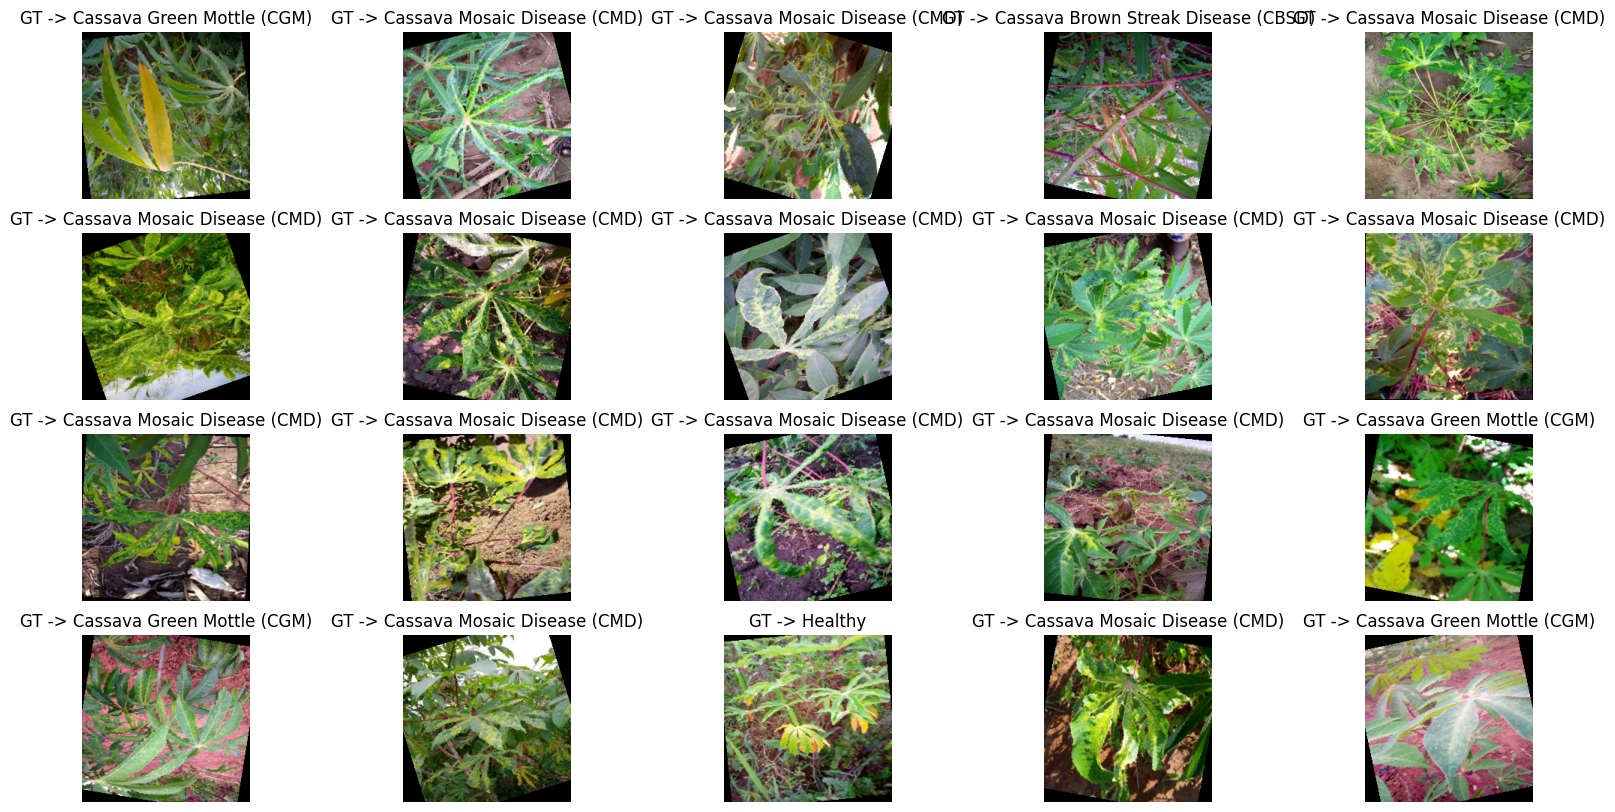

In [3]:
def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.values()))

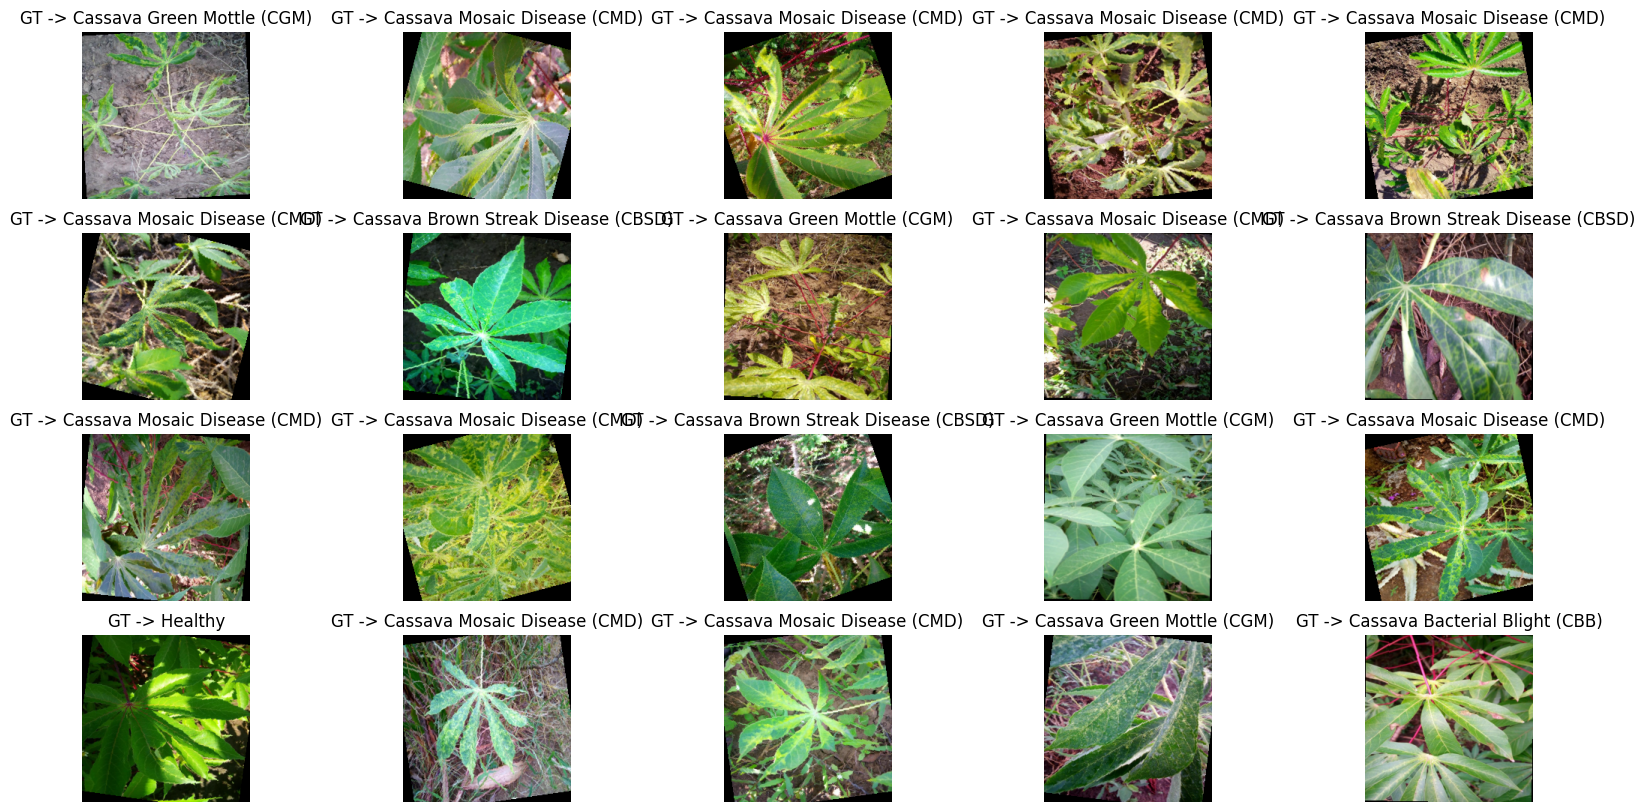

In [4]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.values()))

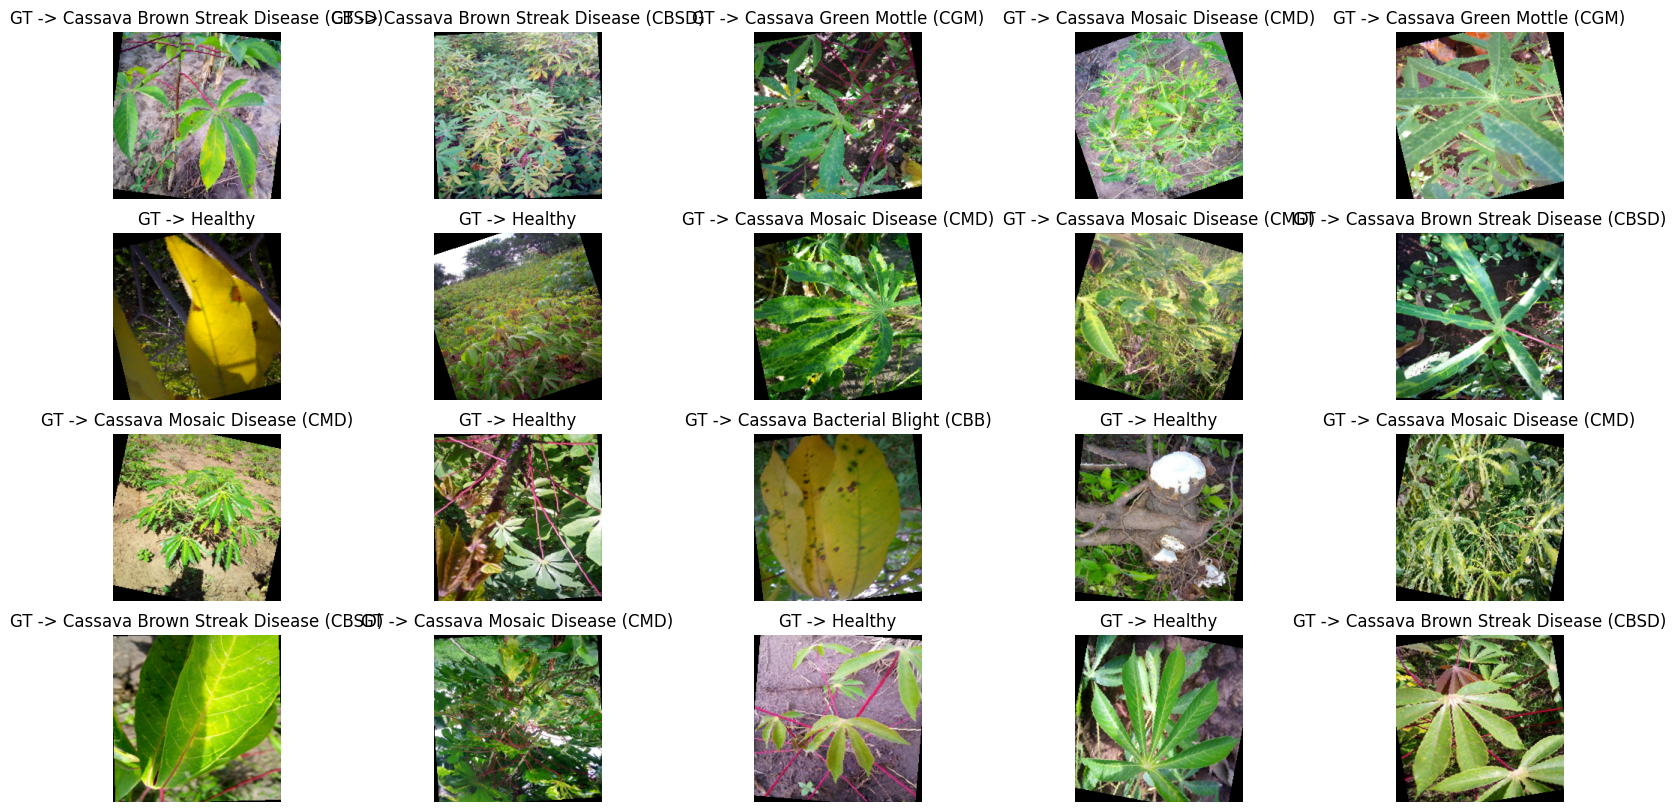

In [5]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.values()))

<ipython-input-6-ff1e220b703f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


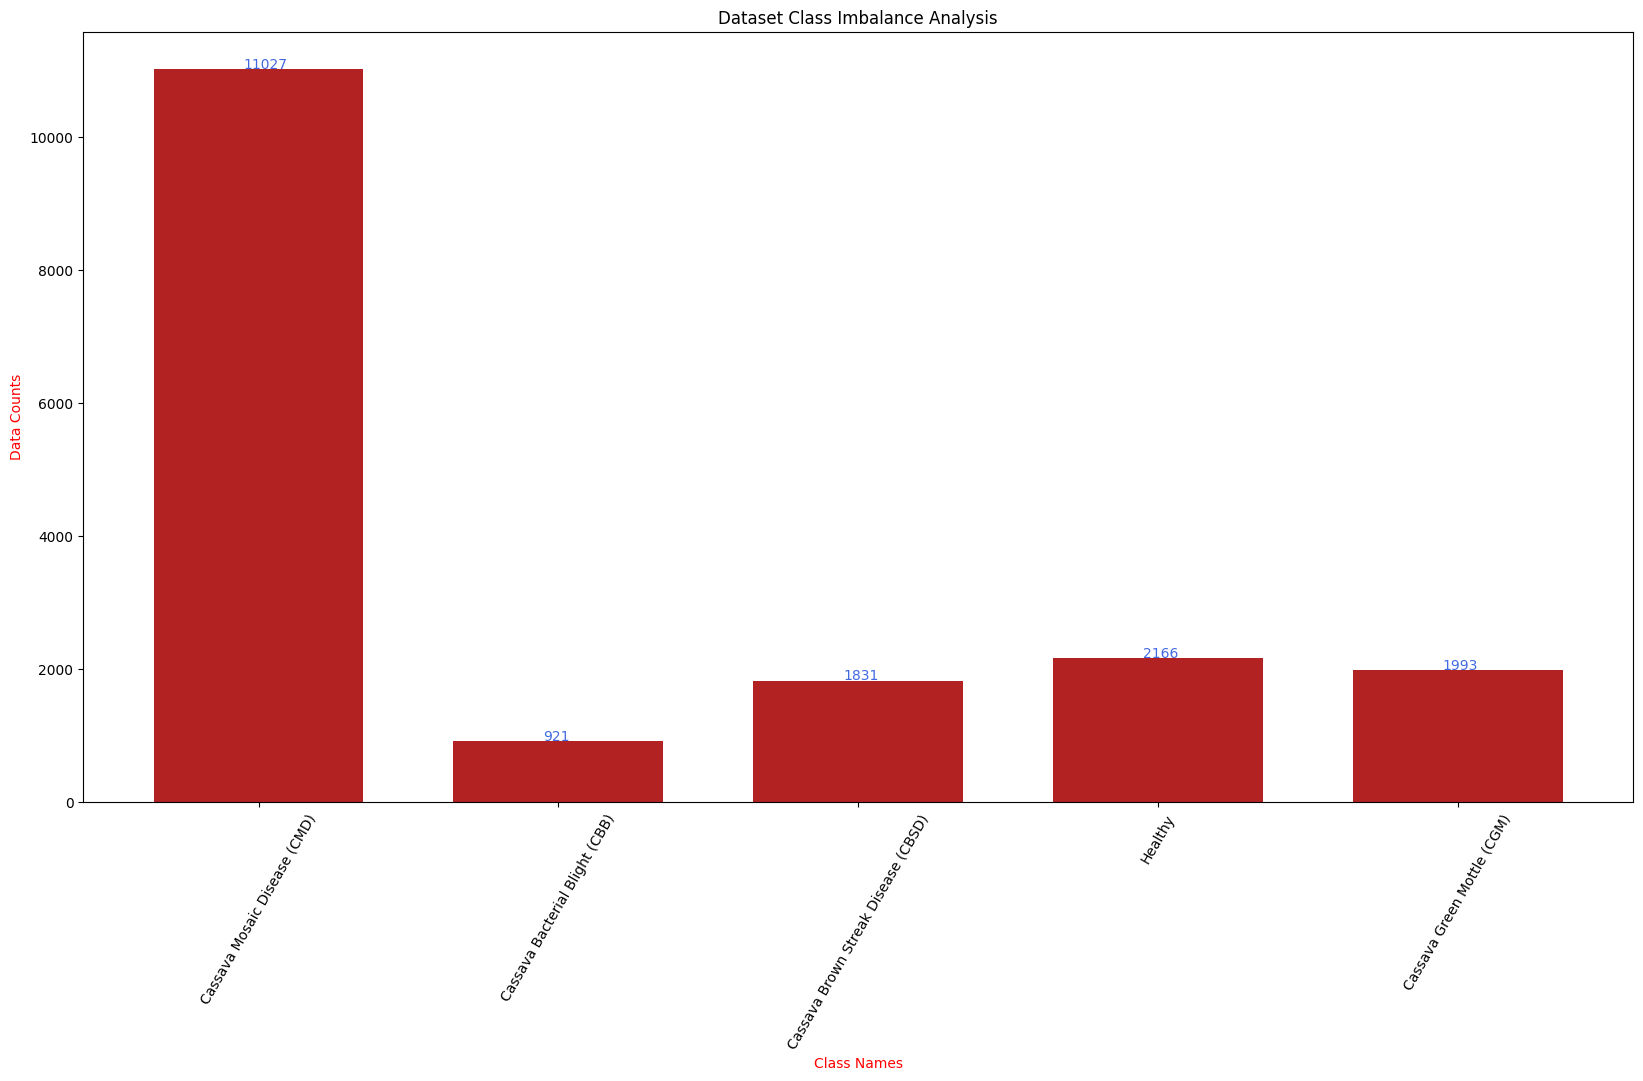

In [6]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

In [7]:
from torch import Tensor
# Define a class for the neural network model
class CustomModel(nn.Module):
    def __init__(self, num_classes,hidden_size=256, kernel_size=3)->None:
        super(CustomModel, self).__init__()
        # Consider adding batch normalization layers after convolutional layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, hidden_size, kernel_size),
            nn.BatchNorm2d(hidden_size),  # Add batch normalization
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.BatchNorm2d(hidden_size),  # Add batch normalization
            nn.MaxPool2d(kernel_size, kernel_size),
            nn.Conv2d(hidden_size, hidden_size, kernel_size),
            nn.BatchNorm2d(hidden_size),  # Add batch normalization
            nn.MaxPool2d(kernel_size, kernel_size)
        )
        # Consider adjusting the number of units in the linear layer
        self.linear = nn.Linear(hidden_size * 7 * 7, hidden_size)
        # No changes in the classification layer
        self.classification = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, image_tensor):
        x = self.conv_block(image_tensor)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.linear(self.relu(x))
        x = self.dropout(x)
        x = self.classification(x)
        return x

# Initialize the model
m = CustomModel(len(classes))

# Define your weights for each class
class_frequencies = torch.tensor([0.6147, 0.0513, 0.1021, 0.1207, 0.1111], dtype=torch.float)

# Calculate the inverse of the frequencies
inverse_frequencies = 1.0 / class_frequencies

# Normalize the inverse frequencies to sum up to 1
class_weights = inverse_frequencies / torch.sum(inverse_frequencies)

# Ensure it's on the appropriate device, for example, CUDA
class_weights = class_weights.to("cuda")

# Print the adjusted class weights
print("Adjusted Class Weights:", class_weights)

# Define the training setup function
def train_setup(m):
    return m.to("cuda").eval(), 30, "cuda", torch.nn.CrossEntropyLoss(weight=class_weights), torch.optim.Adam(params=m.parameters(), lr=3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "crop", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 30
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.ph")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")

Adjusted Class Weights: tensor([0.0338, 0.4044, 0.2032, 0.1719, 0.1867], device='cuda:0')
Start training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0it [00:00, ?it/s]

1-epoch train process is completed!
1-epoch train loss          -> 1.124
1-epoch train accuracy      -> 0.610
1-epoch train f1-score      -> 0.611
1-epoch validation process is completed!
1-epoch validation loss     -> 1.021
1-epoch validation accuracy -> 0.611
1-epoch validation f1-score -> 0.624


0it [00:00, ?it/s]

2-epoch train process is completed!
2-epoch train loss          -> 1.033
2-epoch train accuracy      -> 0.633
2-epoch train f1-score      -> 0.634
2-epoch validation process is completed!
2-epoch validation loss     -> 0.999
2-epoch validation accuracy -> 0.637
2-epoch validation f1-score -> 0.649


0it [00:00, ?it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.990
3-epoch train accuracy      -> 0.643
3-epoch train f1-score      -> 0.644
3-epoch validation process is completed!
3-epoch validation loss     -> 0.943
3-epoch validation accuracy -> 0.651
3-epoch validation f1-score -> 0.663


0it [00:00, ?it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.966
4-epoch train accuracy      -> 0.649
4-epoch train f1-score      -> 0.651
4-epoch validation process is completed!
4-epoch validation loss     -> 0.940
4-epoch validation accuracy -> 0.658
4-epoch validation f1-score -> 0.670


0it [00:00, ?it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.944
5-epoch train accuracy      -> 0.650
5-epoch train f1-score      -> 0.652
5-epoch validation process is completed!
5-epoch validation loss     -> 0.923
5-epoch validation accuracy -> 0.651
5-epoch validation f1-score -> 0.663


0it [00:00, ?it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.938
6-epoch train accuracy      -> 0.652
6-epoch train f1-score      -> 0.648
6-epoch validation process is completed!
6-epoch validation loss     -> 0.954
6-epoch validation accuracy -> 0.644
6-epoch validation f1-score -> 0.656
Loss value did not decrease for 1 epochs


0it [00:00, ?it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.939
7-epoch train accuracy      -> 0.658
7-epoch train f1-score      -> 0.659
7-epoch validation process is completed!
7-epoch validation loss     -> 0.876
7-epoch validation accuracy -> 0.640
7-epoch validation f1-score -> 0.652


0it [00:00, ?it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.896
8-epoch train accuracy      -> 0.668
8-epoch train f1-score      -> 0.670
8-epoch validation process is completed!
8-epoch validation loss     -> 0.844
8-epoch validation accuracy -> 0.657
8-epoch validation f1-score -> 0.669


0it [00:00, ?it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.893
9-epoch train accuracy      -> 0.671
9-epoch train f1-score      -> 0.669
9-epoch validation process is completed!
9-epoch validation loss     -> 0.945
9-epoch validation accuracy -> 0.611
9-epoch validation f1-score -> 0.624
Loss value did not decrease for 2 epochs


0it [00:00, ?it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.876
10-epoch train accuracy      -> 0.675
10-epoch train f1-score      -> 0.675
10-epoch validation process is completed!
10-epoch validation loss     -> 0.873
10-epoch validation accuracy -> 0.674
10-epoch validation f1-score -> 0.685
Loss value did not decrease for 3 epochs


0it [00:00, ?it/s]

11-epoch train process is completed!
11-epoch train loss          -> 0.861
11-epoch train accuracy      -> 0.676
11-epoch train f1-score      -> 0.673
11-epoch validation process is completed!
11-epoch validation loss     -> 0.874
11-epoch validation accuracy -> 0.672
11-epoch validation f1-score -> 0.683
Loss value did not decrease for 4 epochs


0it [00:00, ?it/s]

12-epoch train process is completed!
12-epoch train loss          -> 0.863
12-epoch train accuracy      -> 0.678
12-epoch train f1-score      -> 0.677
12-epoch validation process is completed!
12-epoch validation loss     -> 0.844
12-epoch validation accuracy -> 0.669
12-epoch validation f1-score -> 0.680


0it [00:00, ?it/s]

13-epoch train process is completed!
13-epoch train loss          -> 0.831
13-epoch train accuracy      -> 0.683
13-epoch train f1-score      -> 0.683
13-epoch validation process is completed!
13-epoch validation loss     -> 0.807
13-epoch validation accuracy -> 0.684
13-epoch validation f1-score -> 0.695


0it [00:00, ?it/s]

14-epoch train process is completed!
14-epoch train loss          -> 0.822
14-epoch train accuracy      -> 0.683
14-epoch train f1-score      -> 0.685
14-epoch validation process is completed!
14-epoch validation loss     -> 0.801
14-epoch validation accuracy -> 0.668
14-epoch validation f1-score -> 0.679


0it [00:00, ?it/s]

15-epoch train process is completed!
15-epoch train loss          -> 0.814
15-epoch train accuracy      -> 0.684
15-epoch train f1-score      -> 0.686
15-epoch validation process is completed!
15-epoch validation loss     -> 0.875
15-epoch validation accuracy -> 0.649
15-epoch validation f1-score -> 0.661
Loss value did not decrease for 5 epochs


0it [00:00, ?it/s]

16-epoch train process is completed!
16-epoch train loss          -> 0.808
16-epoch train accuracy      -> 0.686
16-epoch train f1-score      -> 0.687
16-epoch validation process is completed!
16-epoch validation loss     -> 0.853
16-epoch validation accuracy -> 0.671
16-epoch validation f1-score -> 0.682
Loss value did not decrease for 6 epochs


0it [00:00, ?it/s]

17-epoch train process is completed!
17-epoch train loss          -> 0.812
17-epoch train accuracy      -> 0.695
17-epoch train f1-score      -> 0.694
17-epoch validation process is completed!
17-epoch validation loss     -> 0.827
17-epoch validation accuracy -> 0.670
17-epoch validation f1-score -> 0.682
Loss value did not decrease for 7 epochs


0it [00:00, ?it/s]

18-epoch train process is completed!
18-epoch train loss          -> 0.783
18-epoch train accuracy      -> 0.703
18-epoch train f1-score      -> 0.703
18-epoch validation process is completed!
18-epoch validation loss     -> 0.780
18-epoch validation accuracy -> 0.684
18-epoch validation f1-score -> 0.695


0it [00:00, ?it/s]

19-epoch train process is completed!
19-epoch train loss          -> 0.778
19-epoch train accuracy      -> 0.706
19-epoch train f1-score      -> 0.704
19-epoch validation process is completed!
19-epoch validation loss     -> 0.808
19-epoch validation accuracy -> 0.688
19-epoch validation f1-score -> 0.699
Loss value did not decrease for 8 epochs


0it [00:00, ?it/s]

20-epoch train process is completed!
20-epoch train loss          -> 0.778
20-epoch train accuracy      -> 0.697
20-epoch train f1-score      -> 0.698
20-epoch validation process is completed!
20-epoch validation loss     -> 0.787
20-epoch validation accuracy -> 0.689
20-epoch validation f1-score -> 0.699


0it [00:00, ?it/s]

21-epoch train process is completed!
21-epoch train loss          -> 0.770
21-epoch train accuracy      -> 0.701
21-epoch train f1-score      -> 0.704
21-epoch validation process is completed!
21-epoch validation loss     -> 0.769
21-epoch validation accuracy -> 0.698
21-epoch validation f1-score -> 0.709


0it [00:00, ?it/s]

22-epoch train process is completed!
22-epoch train loss          -> 0.760
22-epoch train accuracy      -> 0.710
22-epoch train f1-score      -> 0.709
22-epoch validation process is completed!
22-epoch validation loss     -> 0.791
22-epoch validation accuracy -> 0.673
22-epoch validation f1-score -> 0.684
Loss value did not decrease for 9 epochs


0it [00:00, ?it/s]

23-epoch train process is completed!
23-epoch train loss          -> 0.746
23-epoch train accuracy      -> 0.708
23-epoch train f1-score      -> 0.709
23-epoch validation process is completed!
23-epoch validation loss     -> 0.779
23-epoch validation accuracy -> 0.682
23-epoch validation f1-score -> 0.693


0it [00:00, ?it/s]

24-epoch train process is completed!
24-epoch train loss          -> 0.742
24-epoch train accuracy      -> 0.708
24-epoch train f1-score      -> 0.710
24-epoch validation process is completed!
24-epoch validation loss     -> 0.758
24-epoch validation accuracy -> 0.695
24-epoch validation f1-score -> 0.705


0it [00:00, ?it/s]

25-epoch train process is completed!
25-epoch train loss          -> 0.736
25-epoch train accuracy      -> 0.715
25-epoch train f1-score      -> 0.715
25-epoch validation process is completed!
25-epoch validation loss     -> 0.781
25-epoch validation accuracy -> 0.680
25-epoch validation f1-score -> 0.691
Loss value did not decrease for 10 epochs
Stop training since loss value did not decrease for 10 epochs.


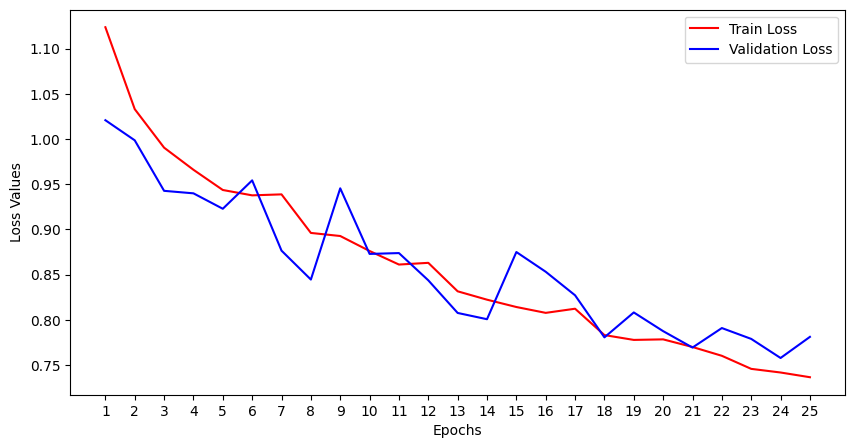

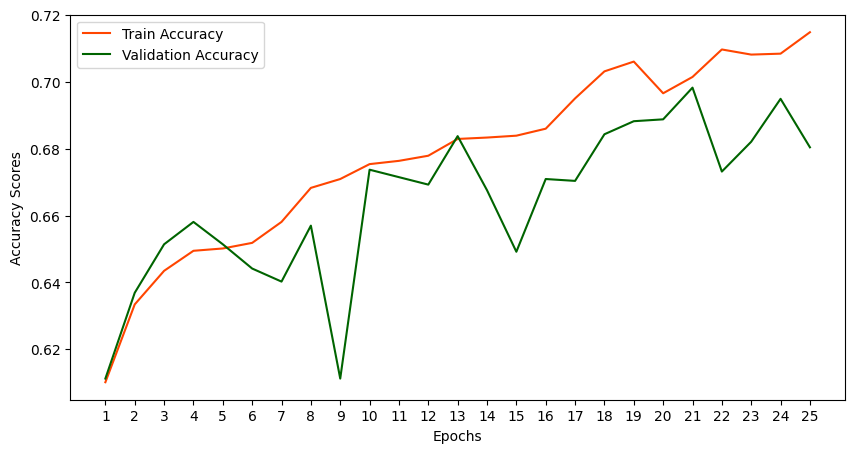

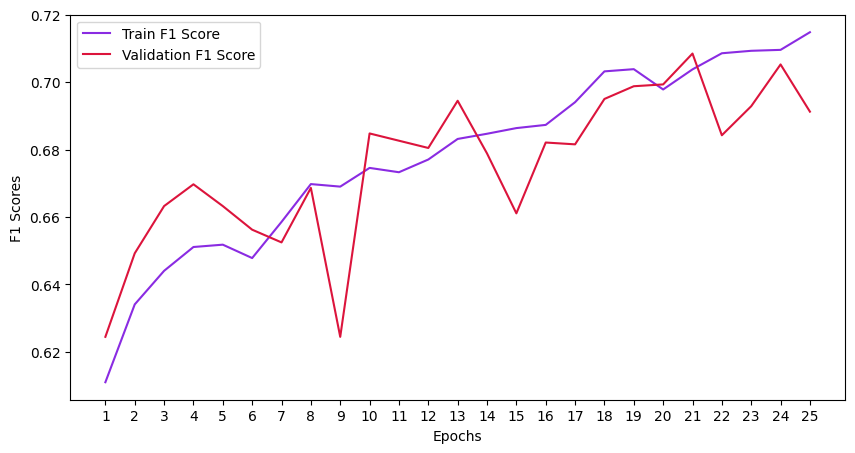

In [9]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()

    def visualize(self):

        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()